Data =  https://secure.ecs.soton.ac.uk/noteswiki/images/internet-traffic-data-in-bits- 

It contains internet traffic data (in bits) of a academic backbone network in the UK. It was collected between 19 November 2004 and 27 January 2005. Data were collected at five minute intervals.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
data = pd.read_excel('internet-traffic-data-in-bits-fr.xlsx')
data.shape

(19888, 2)

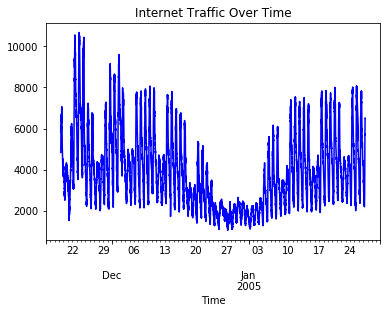

Time
2004-11-19 09:30:00    4838.665
2004-11-19 09:35:00    4845.177
2004-11-19 09:40:00    5157.996
2004-11-19 09:45:00    5637.876
2004-11-19 09:50:00    5520.690
dtype: float64

In [2]:
time = data.iloc[:, 0]
traffic = np.array(data.iloc[:, 1])
ts = pd.Series(traffic, index=time)
ts.plot(c='b', title = 'Internet Traffic Over Time')
plt.show()
ts.head()

In [3]:
# Converting data into array that can be broken up into batches
TS = np.array(ts)
num_periods = 20 # periods of 'train' data 
f_horizon = 1 # forecasting one period after the 20 

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1, 20, 1)

y_data = TS[1: (len(TS) - (len(TS) % num_periods)) + f_horizon]
y_batches = y_data.reshape(-1, 20, 1)

In [4]:
# Pulling out our test data
def test_data(series, forecast,num_periods):
    test_x_setup = TS[-(num_periods + forecast):]
    testX = test_x_setup[:num_periods].reshape(-1, 20, 1)
    testY = TS[-(num_periods):].reshape(-1, 20, 1)
    return testX, testY
X_test, y_test = test_data(TS, f_horizon, num_periods)

Implementing RNN using tensorflow, training it on the provided data. Tweaking hyperparameters based on training times / convergence towards optimal parameters

In [20]:
import tensorflow as tf
tf.reset_default_graph()

num_periods = 20     # no.periods per vector we are using to predict one period ahead
inputs = 1           # no. vectors submitted
hidden = 15          # no.neurons to work through recursively
output = 1           # no. output vectors

X = tf.placeholder(tf.float32, [None, num_periods, inputs]) # creating variable objects
y = tf.placeholder(tf.float32, [None, num_periods, inputs])

basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu) # creates our RNN object
rnn_output, states = tf.nn.dynamic_rnn(basic_cell, X, dtype = tf.float32) # dynamic over state

learning_rate = 0.00000000001 # small learning rate so don't overshoot minimum

stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden]) # change the form into a tensor
stacked_outputs = tf.layers.dense(stacked_rnn_output, output) # specify the type of layer (dense)
outputs = tf.reshape(stacked_outputs, [-1, num_periods, output]) # shape of the results

loss = tf.reduce_mean(tf.square(outputs-y)) # defining cost function which evaluates quality of the model
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) # gradient descent method (mean or sum?)
training_op = optimizer.minimize(loss) # train the result of the application of the cost_function

init = tf.global_variables_initializer() # initiliase all the variables

In [22]:
# implementing this model on training data
epochs = 500
epoch_values = []
# SGD_RMSE_values = []
ADAM_RMSE_values = []
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op, feed_dict={X: x_batches, y: y_batches})
        if ep % 100 == 0:
            mse = loss.eval(feed_dict = {X: x_batches, y: y_batches})
            print(ep, '\tRMSE:', math.sqrt(mse))
            epoch_values.append(ep)
#             SGD_RMSE_values.append(math.sqrt(mse))
            ADAM_RMSE_values.append(math.sqrt(mse))
    y_pred = sess.run(outputs, feed_dict={X: X_test})
    print(y_pred)

0 	RMSE: 3567.957819257397
100 	RMSE: 97.97000597281037
200 	RMSE: 94.85079257213668
300 	RMSE: 94.59741486128202
400 	RMSE: 94.47829095055383
[[[5150.2515]
  [5368.6533]
  [5382.4346]
  [5497.7095]
  [5719.2026]
  [5650.359 ]
  [5710.175 ]
  [5677.3955]
  [5833.3276]
  [5921.811 ]
  [6035.5703]
  [6138.368 ]
  [6189.186 ]
  [6240.2896]
  [6302.1377]
  [6436.0527]
  [6513.461 ]
  [6289.0996]
  [6301.0854]
  [6420.714 ]]]


Comparing SGD v Adam Optimiser performances

Text(0,0.5,'RMSE')

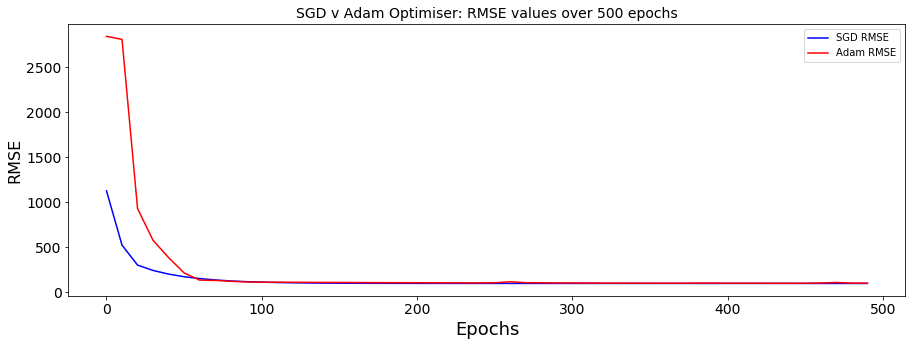

In [102]:
plt.figure(figsize=(15,5))
plt.title('SGD v Adam Optimiser: RMSE values over 500 epochs', fontsize = 14)
plt.plot(epoch_values, SGD_RMSE_values, 'b', markersize=10, label='SGD RMSE')
plt.plot(epoch_values, ADAM_RMSE_values, 'r', markersize=10, label='Adam RMSE')
plt.legend(loc='upper right')
plt.tick_params(labelsize=14)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('RMSE', fontsize=16)

In [101]:
print('SGD values :', min(SGD_RMSE_values), 'Adam values :', min(ADAM_RMSE_values))

SGD values : 93.97424223224681 Adam values : 96.58639469731231


Text(0,0.5,'RMSE')

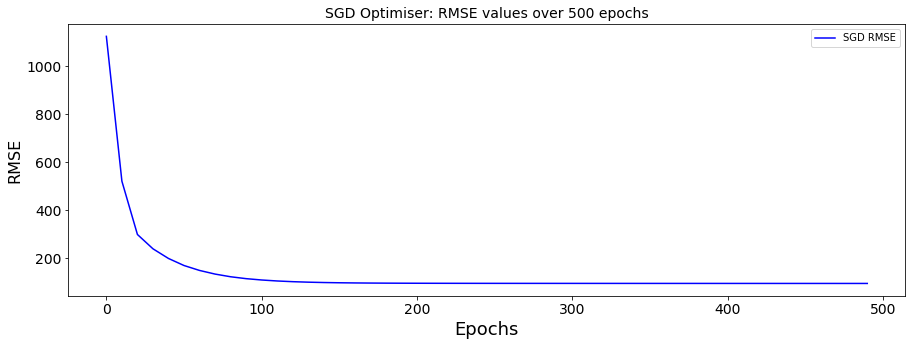

In [98]:
plt.figure(figsize=(15,5))
plt.title('SGD Optimiser: RMSE values over 500 epochs', fontsize = 14)
plt.plot(epoch_values, SGD_RMSE_values, 'b', markersize=10, label='SGD RMSE')
plt.legend(loc='upper right')
plt.tick_params(labelsize=14)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('RMSE', fontsize=16)

Plotting model forecast to test data

Text(0.5,0,'Time periods')

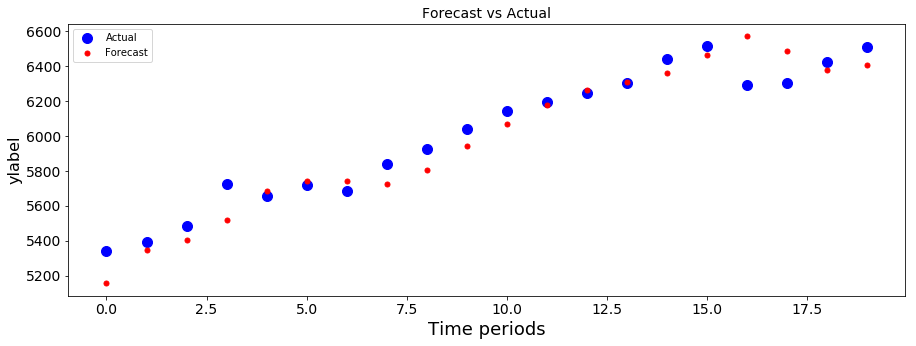

In [19]:
plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual', fontsize = 14)
plt.plot(pd.Series(np.ravel(y_test)), 'bo', markersize=10, label='Actual')
plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label='Forecast')
plt.legend(loc='upper left')
plt.tick_params(labelsize=14)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=16)
plt.xlabel('Time periods')